<a href="https://colab.research.google.com/github/Andrewpensoneault/tensor_train_RNN/blob/master/TLSTM_Lorenz_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tensor RNN for the Lorenz 63'
- For training, I shall look at Lorenz 63' model with where 

$$\frac{dx}{dt} = \sigma (y-x)$$
$$\frac{dy}{dt} = x(\rho-z)-y$$
$$\frac{dz}{dt} = xy-\beta z$$
- We will use the choice of parameters $\sigma = 10$, $\beta = 8/3$, $\rho=28$. 
- This choice of parameters creates a system which is highly chaotic, and is a simplification of many complex systems in a variety of applications.
- Thus we shall view it as a starting point to see if a neural network surrogate model can be created to accurately perform long term forecasting based on partial observation Data Assimilation
- This code is based off *Long-term Forecasting using Tensor-Train RNNs* from Yu et al.
- The TRNN code is provided from the corresponding [GitHub](https://github.com/yuqirose/tensor_train_RNN/blob/master/data.npy) repository
- Future plans include getting code to work for Lorenz 96' model and potentially implementing the order reduction seen in [Vlachas et al.](https://arxiv.org/pdf/1802.07486.pdf)

### Copy GitHub directory, import libraries

In [0]:
# Get files necessary for running script
import os
from google.colab import drive
!git clone https://github.com/Andrewpensoneault/tensor_train_RNN
os.chdir('tensor_train_RNN')
if (os.path.isdir("./data")) == False:
  !mkdir data
if (os.path.isdir("./figures")) == False:
  !mkdir figures
!rm -r .git

fatal: destination path 'tensor_train_RNN' already exists and is not an empty directory.
rm: cannot remove '.git': No such file or directory


In [0]:
# importing required modules 
from zipfile import ZipFile 
import os       

# Functions that will be used 
from __future__ import division
from __future__ import print_function

import importlib
from six.moves import xrange 

import numpy 
import numpy as np

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed
import tensorflow as tf
from tensorflow.contrib import rnn

from reader import read_data_sets
import reader
from model_seq2seq import *
from trnn import *
from train_config import *

from scipy import fftpack
from scipy import integrate
from scipy import linalg

import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from timeit import default_timer as timer
import shutil
from zipfile import ZipFile
from google.colab import files

In [0]:
# Functions to zip and unzip files
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = './'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    print('Following files will be zipped:') 
    for file_name in file_paths: 
        print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('tensor_train_RNN.zip','w') as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
    print('All files zipped successfully!')  

### Models to test against and other necessary functions

In [0]:
# List of models to use
def lorenz_96 (x,t,F = 8): 
  xp1 = np.roll(x,-1)
  xm1 = np.roll(x,1)
  xm2 = np.roll(x,2)
  y = (xp1 - xm2)*xm1 - x + F
  return y

def lorenz_63 (x,t,s = 10, b=8/3, r=28):
  y = np.zeros(3)
  y[0] = s*(x[1]-x[0])
  y[1] = x[0]*(r-x[2])-x[1]
  y[2] = x[0]*x[1]-b*x[2]
  return y

# Integrator function
def integrate_current(x,t0,increment,integrate_true):
  integrate_true.set_initial_value(x,t0)
  y = integrate_true.integrate(increment)
  return y

# EnKF function
def SREnKF (Xprior,H,y,Q,R,nbv):
  ens_dim = nbv
  state_dim = H.shape[1]
  meas_dim = H.shape[0]
  m = np.mean(Xprior,1)
  m = m[:,np.newaxis]
  y = y[:,np.newaxis]
  Xpert = Xprior - m
  C = np.matmul(Xpert,np.transpose(Xpert))/(ens_dim - 1)
  CHT = np.matmul(C,np.matrix.transpose(H))    
  S = np.matmul(H,CHT) + R*np.eye((meas_dim))
  K = np.matmul(CHT,np.linalg.inv(S))
  KH = np.matmul(K,H)
  KY = np.matmul(K,y)
  mp = np.matmul(np.identity(state_dim)-KH,m)+KY
  HX = np.matmul(H,Xpert)/math.sqrt(ens_dim - 1)
  T = np.linalg.inv(np.identity(ens_dim)+np.matmul(np.matmul(HX.transpose(),np.linalg.inv(R*np.eye((meas_dim)))),HX))
  Tsqrt = np.linalg.cholesky(T)
  Zeta = np.matmul(Xpert,Tsqrt)
  X = mp + Zeta
  return X

### Edit here to change ODE Model type / RNN Type / Model Parameters / Assimilation Parameters

In [0]:
# Edit this to change type of model
numpy.random.seed(1)          # Sets initial seed to reproduce results
model_name = 'tlstm'.lower()  # Either RNN / LSTM / TLSTM
model_ode = lorenz_63         # Either lorenz_96 or lorenz_63
sampsize = 100000             # Sample Size
timelen = 20                  # Total span of forecast including input sample
increment = .01               # Increment time for sample
Q_pert = .01                  # Standard deviation for samples 
inp_steps = 10                # Initial time to feed into model
batch_size = 100              # Batch Size
training_steps = 50000        # Number of training steps
hidden_size = 50              # Number of stacked hidden cell layers
learning_rate = 3e-3          # Learning rate
decay_rate = .95              # Rate of learning rate decay for rmsprop
rank = list([10])                                        # Rank of polynomial for tt decomposition
save_path = "./log/" + model_name + "/"                  # Path to save model information
model = model_name.upper()                               # Model name used for training
data_path = "./data/data_"+ model_ode.__name__ +".npy"   # Data file location
out_steps = None                                         # Test steps
display_step = 2000           # Display the validation ever n steps
sampling_burn_in = 400        # Burn in steps for sampling
generate_data = True          # Generate Data if True
load_model = True             # Skips the model training and loads the model parameters
sample_test = 4               # Sample plot from the test
save_results = False          # Save results and download
gen_log_loss = True           # Generate the complete log-log figure
time_test = True              # Generate the time comparison

# Assimilation Parameters
n_cycle = 100                 # Number of assimilation steps
n_size = 150                  # Number of particles for assimilation
Q_init = .01                  # Variance of initial condition (In unnormalized space)
Q = .001                      # Variance of model (In normalized space)
R = .00001                    # Variance of sensor (In normalized space)

# Gets the dimension size based on the model
if model_ode.__name__ == 'lorenz_96':
  N=40
  mp_normal = np.random.normal(0,1,(N)) #Mean of the initial condition (unnormalized)
  H = np.zeros((math.floor(N/2),N))       #Measurement operator 50%
  for i in range(0,math.floor(N/2)):
    H[i,2*i] = 1

elif model_ode.__name__ == 'lorenz_63':
  N=3
  mp_normal = np.random.normal(0,1,(N)) #Mean of the initial condition (unnormalized)
  H = np.eye(N-1,N)                       #Measurement operator 66%

### Generate Data

In [0]:
# Generate Data
if generate_data == True:
  x = np.zeros((sampsize,timelen,N))
  x[:,0,:] = np.random.uniform(-40,40,size=(sampsize,N))
  for sampnum in tqdm(range(0,sampsize)):
    tmp = integrate.odeint(model_ode, y0 = x[sampnum,0,:], t = np.arange(0, (timelen+1)*increment, increment),full_output = 0)
    x[sampnum,range(1,timelen),:] = tmp[range(1,timelen),:]
  x = x + np.random.normal(0,Q_pert,(sampsize,timelen,N))
  np.save(data_path, x)
elif generate_data == False:
  with ZipFile('./data/data_' + model_ode.__name__ + '.zip', 'r') as zip: 
    zip.extractall()

100%|██████████| 100000/100000 [01:11<00:00, 1395.79it/s]


### Read flags and data into memory

In [0]:
#To forecast time series using a recurrent neural network, we consider every row as a short time series.

# Training Parameters
config = TrainConfig()
config.hidden_size = hidden_size
config.learning_rate = learning_rate
config.decay_rate = decay_rate
config.rank_vals = rank
config.batch_size = batch_size
config.training_steps = training_steps
config.inp_steps = inp_steps
use_sched_samp = False

# Training Parameters
training_steps = config.training_steps
batch_size = config.batch_size
inp_steps = config.inp_steps
out_steps = out_steps


# Read Dataset (and normalize)
dataset, stats = read_data_sets(data_path, True, inp_steps, out_steps)

# Network Parameters
num_input = stats['num_input']  # dataset data input (time series dimension: 3)
num_steps = stats['num_steps']

if out_steps is None:
    # Forecast for the rest if horizon is not set
    out_steps = num_steps - inp_steps
# Print training config
print('-'*100)
print('|input steps|', inp_steps, '|out steps|', out_steps ,'|', 'hidden size|',config.hidden_size, '|learning rate|', config.learning_rate, '|rank val|', config.rank_vals)
print('-'*100)

loading time series ...
input type  <class 'numpy.ndarray'> (100000, 20, 3)
normalize to (0-1)
----------------------------------------------------------------------------------------------------
|input steps| 10 |out steps| 10 | hidden size| 50 |learning rate| 0.003 |rank val| [10]
----------------------------------------------------------------------------------------------------


### Visualize short term visualizations

In [0]:
# Saves max and min of a dataset (necessary in transformations in data assimilation)
data = np.load(data_path)
norm_data, norm_stats = reader.normalize_columns(data)
np.save('./data/norm_stats_'+ model_name +'.npy',norm_stats)
# Expand the dimension if univariate time series
if (np.ndim(data)==1):
  data = np.expand_dims(data, axis=1)

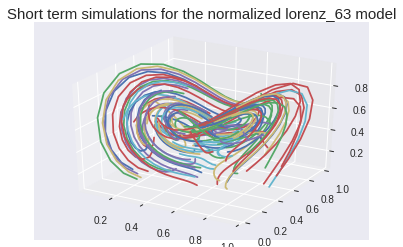

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0,100):
  ax.plot(xs = np.squeeze(data[i,:,0]),ys =np.squeeze(data[i,:,1]),zs = np.squeeze(data[i,:,2]))
ax.set_title(label = 'Short term simulations for the normalized '+model_ode.__name__ +' model', fontsize = 15,y=1.08)
if generate_data == True:
  plt.savefig('./figures/Assim_'+ model_ode.__name__ + '_short_term.png')

### Build the neural network models
Building seq2seq model for training/validation/testing,
validation and testing models are shared,
scheduled sampling is by default off 

In [0]:
# tf Graph input
X = tf.placeholder("float", [None, inp_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])

# Decoder output
Z = tf.placeholder("float", [None, out_steps, num_input])

Model = globals()[model]
with tf.name_scope("Train"):
    with tf.variable_scope("Model", reuse=None):
        train_pred = Model(X, Y, True,  config)
with tf.name_scope("Test"):
    with tf.variable_scope("Model", reuse=True):
        test_pred = Model(X, Y, False,  config)

# Define loss and optimizer
train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Z)))
test_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(test_pred, Z)))

# Exponential learning rate decay 
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = config.learning_rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           2000, config.decay_rate, staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_op = optimizer.minimize(train_loss,global_step=global_step)

# Scheduled sampling params
eps_min = 0.1 # minimal prob

# Write summary
train_summary = tf.summary.scalar('train_loss', train_loss)
valid_summary = tf.summary.scalar('valid_loss', test_loss)
lr_summary = tf.summary.scalar('learning_rate', learning_rate)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver for the model and loss
saver = tf.train.Saver()
hist_loss =[]

Training -->
          Create Encoder ...
          Create Decoder ...
Testing -->
          Create Encoder ...
          Create Decoder ...


### Training loop
This may take a while, training loss is displayed at every 2000 steps, 
use GPU can speed up training

In [0]:
# Start training
print('training parameters = ', np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
print('-------------------------------------------------')
if load_model == False:  
  with tf.Session() as sess:
    # Merge all the summaries and write them out to /log/model_name (by default)
    merged = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(save_path,sess.graph)

    # Run the initializer
    sess.run(init)    
    
    for step in tqdm(range(1, training_steps+1)):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, Z:batch_z})
        if step % display_step == 0 or step == 1:
              
            # Calculate batch loss 
            summary, loss = sess.run([merged,train_loss], feed_dict={X: batch_x,Y: batch_y, Z:batch_z})
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            summary_writer.add_summary(summary, step)
            print()
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) )
            
            # Calculate validation
            valid_enc_inps = dataset.validation.enc_inps.reshape((-1, inp_steps, num_input))
            valid_dec_inps = dataset.validation.dec_inps.reshape((-1, out_steps, num_input))
            valid_dec_outs = dataset.validation.dec_outs.reshape((-1, out_steps, num_input))
            va_sum, va_loss = sess.run([valid_summary,test_loss], \
                                       feed_dict={X: valid_enc_inps, Y: valid_dec_inps, Z: valid_dec_outs})
            summary_writer.add_summary(va_sum, step) 
            print("Validation Loss:", va_loss)
            if step == 1:
              training_output = np.array([[step,loss,va_loss]])
            else:
              training_output = np.append(training_output, np.array([[step,loss,va_loss]]),axis=0)

            
            # Overfitting
            hist_loss.append(va_loss)
            if len(hist_loss)>20 and va_loss > np.mean(hist_loss):
                print("Early stopping: step ", step)
                break
          
            #Update sampling prob
            if use_sched_samp and step > sampling_burn_in:
                sample_prob = max(eps_min, 1.0-step/(2*training_steps))
                sess.run(tf.assign(config.sample_prob, sample_prob))
                print('Sampling prob:', sample_prob)

    print("Optimization Finished!")

    # Calculate accuracy for test datasets
    test_enc_inps = dataset.test.enc_inps.reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps.reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs.reshape((-1, out_steps, num_input))

    
    # Fetch the predictions 
    fetches = {
        "true":Z,
        "pred":test_pred,
        "loss":test_loss
    }
    test_vals = sess.run(fetches, feed_dict={X: test_enc_inps, Y: test_dec_inps, Z: test_dec_outs})
    print("Testing Loss:", test_vals["loss"])

    # Save the variables to disk.
    save_path = saver.save(sess, save_path)
    print("Model saved in file: %s" % save_path)
    # Save predictions 
    numpy.save(save_path+"predict.npy", (test_vals["true"], test_vals["pred"]))
    # Save config file
    with open(save_path+"config.out", 'w') as f:
        f.write('hidden_size:'+ str(config.hidden_size)+'\t'+ 'learning_rate:'+ str(config.learning_rate)+ '\n')
        f.write('train_error:'+ str(loss) +'\t'+ 'valid_error:' + str(va_loss) + '\t'+ 'test_error:'+ str(test_vals["loss"]) +'\n')
        
  y_true = test_vals["true"]
  y_pred = test_vals["pred"]

  np.save('./data/y_true_'+ model_ode.__name__ +'_' + model_name + '.npy', y_true)
  np.save('./data/y_pred_'+ model_ode.__name__ +'_'+ model_name +'.npy', y_pred)
  np.save('./data/training_output_'+ model_ode.__name__ +'_'+ model_name + '.npy', training_output)
elif load_model == True:
  y_true = np.load('./data/y_true_'+ model_ode.__name__ +'_' + model_name + '.npy')
  y_pred = np.load('./data/y_pred_'+ model_ode.__name__ +'_'+ model_name +'.npy')
  training_output = np.load('./data/training_output_'+ model_ode.__name__ +'_'+ model_name + '.npy')

training parameters =  417326
-------------------------------------------------


### Visualize predictions

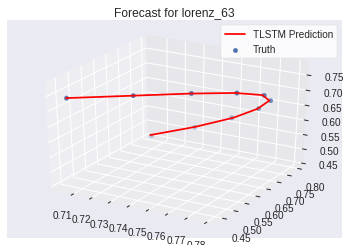

In [0]:
## Forecast Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = np.squeeze(y_true[sample_test,:,0]),ys = np.squeeze(y_true[sample_test,:,1]),zs = np.squeeze(y_true[sample_test,:,2]), label='Truth')
ax.plot(xs = np.squeeze(y_pred[sample_test,:,0]),ys = np.squeeze(y_pred[sample_test,:,1]),zs = np.squeeze(y_pred[sample_test,:,2]), label= model_name.upper() + ' Prediction',color = 'red')
ax.legend(loc='best',frameon=True,facecolor='white',fontsize = 10)
ax.set_title(label = 'Forecast for ' + model_ode.__name__, fontsize = 12,y=1.08)
plt.savefig('./figures/Forecast_'+ model_ode.__name__ +'_'+model_name+'.png')

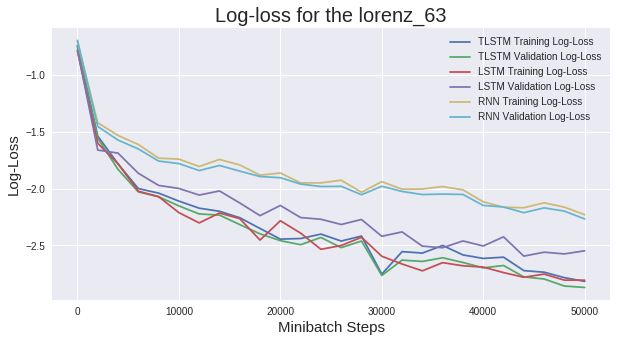

In [0]:
# Generate Log-Loss Plot 
if gen_log_loss == True:
  fig = plt.figure(figsize=(10,5))
  for types in ['tlstm','lstm','rnn']:
    training_output_k = np.load('./data/training_output_'+ model_ode.__name__ +'_'+ types + '.npy')
    plt.plot(training_output_k[:,0],np.log10(training_output_k[:,1]),label = types.upper() + ' Training Log-Loss')
    plt.plot(training_output_k[:,0],np.log10(training_output_k[:,2]),label = types.upper() + ' Validation Log-Loss')
  plt.legend(fontsize = 10)
  plt.xlabel('Minibatch Steps',fontsize = 15)
  plt.ylabel('Log-Loss',fontsize = 15)
  plt.title('Log-loss for the '+ model_ode.__name__ , fontsize = 20)
  plt.savefig('./figures/Log-Loss_'+ model_ode.__name__ +'_'+model_name+'.png')

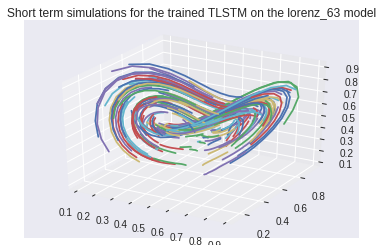

In [0]:
# Short term collection plot
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0,200):
  ax.plot(xs = np.squeeze(y_pred[i,:,0]),ys =np.squeeze(y_pred[i,:,1]),zs =np.squeeze(y_pred[i,:,2]))
ax.set_title(label = 'Short term simulations for the trained ' + model_name.upper() + ' on the '+ model_ode.__name__ + ' model', fontsize = 12,y=1.08)
plt.savefig('./figures/Assim_'+ model_ode.__name__ +'_'+model_name+'_short_term.png')

## Data Assimilation

In [0]:
  # Initialization Step (involving normalization)
  x = np.zeros((n_cycle,timelen,N))
  data = np.zeros((n_cycle,timelen,N)) 
  Xprior = np.zeros((N,n_cycle))
  mp = np.zeros((N,n_cycle+1))
  y = np.zeros((H.shape[0],n_cycle+1))
  Xt = np.zeros((n_cycle,inp_steps,N))

  # Initial Step (and generate true state)
  true = integrate.odeint(model_ode, y0 = mp_normal, t = np.arange(0, (n_cycle+1)*increment*inp_steps, increment*inp_steps), full_output = 0).T
  x[:,0,:] = mp_normal+np.random.normal(0,math.sqrt(Q_init),size=(n_cycle,N))
  if time_test == True:
    start = timer()
  for sampnum in range(0,n_cycle):
    tmp = integrate.odeint(model_ode, y0 = x[sampnum,0,:], t = np.arange(0, (timelen+1)*increment, increment),full_output = 0)
    x[sampnum,range(1,timelen),:] = tmp[range(1,timelen),:]
  if time_test == True:
    end = timer()
    print('Clock Time for ' + model_ode.__name__ + ' with ' + str(n_cycle) + ' samples for ' + str(timelen) + ' timesteps: ', end-start)

  # Convert to normalized space
  for i in range(0,N):
    true[i,:] = (true[i,:] - norm_stats[0,i]) / (norm_stats[1,i] - norm_stats[0,i]) 
    mp[i,0] = (mp_normal[i] - norm_stats[0,i]) / (norm_stats[1,i] - norm_stats[0,i]) 
    data[:,:,i] = (x[:,:,i] - norm_stats[0,i]) / (norm_stats[1,i] - norm_stats[0,i]) 
  enc_inps = data[:,range(0,inp_steps),:]
  dec_inps = np.zeros((n_cycle,inp_steps, num_input))

Clock Time for lorenz_63 with 100 samples for 20 timesteps:  0.048029939999992166


In [0]:
# Generate RMSE
if gen_log_loss == False:
  fig = plt.figure(figsize=(10,5))
  rms_err = np.zeros(n_cycle+1)
  for i in range(0,n_cycle+1):
    rms_err[i] = (np.linalg.norm(mp[:,i]-true[:,i]))/N
  np.save('./data/rms_err' + '_' + model_ode.__name__ + '_' + model_name + '.npy',rms_err)
if gen_log_loss == True:
  # RMSE Plot
  fig = plt.figure()
  for i in ['rnn', 'tlstm']:
    rms_err_i = np.load('./data/rms_err' + '_' + model_ode.__name__ + '_' + i + '.npy')
    plt.plot(rms_err_i,label = 'RMSE for Surrogate models of '  + i.upper() + ' ' + model_ode.__name__)
  plt.legend(fontsize = 10)
  plt.xlabel('Iterations',fontsize = 12)
  plt.ylabel('RMSE',fontsize = 12)
  plt.title('RMSE for the Surrogate ' + model_ode.__name__ + '-EnKF ' , fontsize = 12)
  plt.savefig('./figures/RMSE_assim_'+ model_ode.__name__ +'.png')

# Assimilation Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs = mp[0,:],ys = mp[1,:],zs = mp[2,:], label=model_name.upper() + ' Prediction',color = 'red')
ax.scatter(xs = true[0,:],ys = true[1,:],zs = true[2,:], label='Truth',color = 'blue')
ax.legend(loc='best',frameon=True,facecolor='white')
ax.set_title(label = 'Forecast for ' + model_ode.__name__ + ' with ' + model_name.upper(),y=1.08)
plt.savefig('./figures/Assim_'+ model_ode.__name__ +'_'+model_name+'.png')

### Saves the generated data

In [0]:
if save_results == True:
  files.download('./figures/Assim_'+ model_ode.__name__ +'_'+model_name+'.png')
  files.download('./figures/Assim_'+ model_ode.__name__ +'_'+model_name+'_short_term.png')
  files.download('./figures/Forecast_'+ model_ode.__name__ +'_'+model_name+'.png')
  files.download('./figures/Assim_'+ model_ode.__name__ + '_short_term.png')
  if gen_log_loss == True:
    files.download('./figures/RMSE_assim_'+ model_ode.__name__ +'.png')
    files.download('./figures/Log-Loss_'+ model_ode.__name__ +'_'+model_name+'.png')
  else:
    files.download('./data/rms_err' + '_' + model_ode.__name__ + '_' + model_name + '.npy')
  if load_model == False:
    files.download('./data/y_true_'+ model_ode.__name__ +'_' + model_name + '.npy')
    files.download('./data/y_pred_'+ model_ode.__name__ +'_'+ model_name +'.npy')
    files.download('./data/training_output_'+ model_ode.__name__ +'_'+ model_name + '.npy')
    for i in os.listdir('./log/'+model_name):
      files.download('./log/'+model_name+'/'+i)